In [1]:
# we first define the autoencoder's architecture:

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.models import load_model
from keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt

def conv_net():
    input_img = Input(shape=(60, 800, 1))  # adapt this if using `channels_first` image data format   
    e1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    e2 = MaxPooling2D((2, 1), padding='same')(e1)
    e3 = Conv2D(32, (10, 10), activation='relu', padding='same')(e2)
    e4 = MaxPooling2D((3, 1), padding='same')(e3)
    e5 = Conv2D(8, (20, 20), activation='relu', padding='same')(e4)
    e6 = MaxPooling2D((2, 1), padding='same')(e5)
    e7 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(e6)
    e8 = MaxPooling2D((5, 1), padding='same')(e7)
    return Model(input_img, e8)

Using TensorFlow backend.


In [2]:
# define input to the model:
x = Input(shape=(60, 800, 1))

# make the model:
model = conv_net()

# compile the model:
model.compile(optimizer='adadelta', loss='binary_crossentropy')

In [3]:
# SEE INSIDE THE MODEL:
# conv_net().summary() #or
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 60, 800, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 800, 32)       320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 800, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 800, 32)       102432    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 800, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 800, 8)        102408    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 800, 8)         0         
__________

In [4]:
# get the Dataset:

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.io as sio

# load data from the .mat file:
mat_contents = sio.loadmat('EEG_data.mat')
X = mat_contents['X']
Y = mat_contents['Y']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)
print('Original data type:', x_train.dtype)

# convert to float64 for numerical stability:
x_train = x_train.astype('float64')
y_train = y_train.astype('float64')
x_test = x_test.astype('float64')
y_test = y_test.astype('float64')

# normalize to unit variance and zero mean:
for i in range(x_train.shape[0]):
    x_train[i,:,:] = preprocessing.scale(x_train[i,:,:], axis=1)
    x_train[i,:,:] = preprocessing.minmax_scale(x_train[i,:,:], axis=1)
    y_train[i,:] = preprocessing.scale(y_train[i,:], axis=0)
    y_train[i,:] = preprocessing.minmax_scale(y_train[i,:], axis=0)

for i in range(x_test.shape[0]):
    x_test[i,:,:] = preprocessing.scale(x_test[i,:,:], axis=1)
    x_test[i,:,:] = preprocessing.minmax_scale(x_test[i,:,:], axis=1)
    y_test[i,:] = preprocessing.scale(y_test[i,:], axis=0)
    y_test[i,:] = preprocessing.minmax_scale(y_test[i,:], axis=0)

# ensure the tensors are sized right:
x_train = np.expand_dims(x_train,3)
x_test = np.expand_dims(x_test,3)
y_test = np.expand_dims(y_test,1)
y_test = y_test[:,:,:,None]
y_train = np.expand_dims(y_train,1)
y_train = y_train[:,:,:,None]

# convert to float16 to save space:
x_train = x_train.astype('float16')
y_train = y_train.astype('float16')
x_test = x_test.astype('float16')
y_test = y_test.astype('float16')
print('Normalized data type:', x_train.dtype)

print('test input shape', x_test.shape, "Nomralized MEAN:", np.mean(x_test), "min", np.min(x_test),"max", np.max(x_test))
print('train input shape', x_train.shape, "Nomralized MEAN:", np.mean(x_train), "min", np.min(x_train),"max", np.max(x_train))

print('test labels shape', y_test.shape, "Nomralized MEAN:", np.mean(y_test), "min", np.min(y_test),"max", np.max(y_test))
print('train labels shape', y_train.shape, "Nomralized MEAN:", np.mean(y_train), "min", np.min(y_train),"max", np.max(y_train))

Original data type: float32
Normalized data type: float16
test input shape (18, 60, 800, 1) Nomralized MEAN: 0.52197 min 0.0 max 1.0
train input shape (72, 60, 800, 1) Nomralized MEAN: 0.52002 min 0.0 max 1.0
test labels shape (18, 1, 800, 1) Nomralized MEAN: 0.49707 min 0.0 max 1.0
train labels shape (72, 1, 800, 1) Nomralized MEAN: 0.49756 min 0.0 max 1.0


Text(0.5,1,'Channels 11 in test samples 6 and 16')

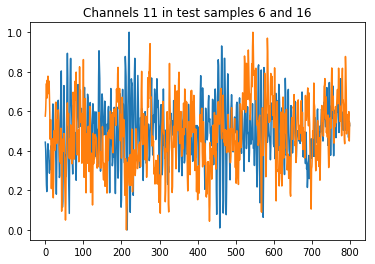

In [5]:
# inspect channel ___ sample
chan = 30
samp = 12
%matplotlib inline
plt.plot(range(0, 800), x_test[samp, chan,:,0], range(0,800), y_test[samp,0,:,0])
ax = plt.gca()
ax.set_title("Channels 11 in test samples 6 and 16")

In [6]:
# Training time!

model.fit(x_train, y_train,
                epochs=20,
                batch_size=30,
                shuffle=True,
                validation_data=(x_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

# save the entire model and the weights after the training:
model.save('EEGnet.h5')
model.save_weights('EEGnet_weights.h5')

Train on 72 samples, validate on 18 samples
Epoch 1/20
72/72 [==============================] - 3s 38ms/step - loss: 0.6932 - val_loss: 0.6937
Epoch 2/20
72/72 [==============================] - 0s 7ms/step - loss: 0.6933 - val_loss: 0.6932
Epoch 3/20
72/72 [==============================] - 0s 7ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/20
72/72 [==============================] - 0s 7ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 5/20
72/72 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/20
72/72 [==============================] - 0s 7ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/20
72/72 [==============================] - 1s 7ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/20
72/72 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/20
72/72 [==============================] - 0s 7ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 10/20
72/72 [==============================] - 0s 7ms/step - loss: 

In [7]:
# let's predict a TRAINING sammple:
decoded_train = model.predict(x_train)
decoded_test = model.predict(x_test)
print(decoded_train.shape)
print(decoded_test.shape)

(72, 1, 800, 1)
(18, 1, 800, 1)


Pearson's R: [-0.11575014] p-value [ 0.00103876]


Text(0.5,1,'Original')

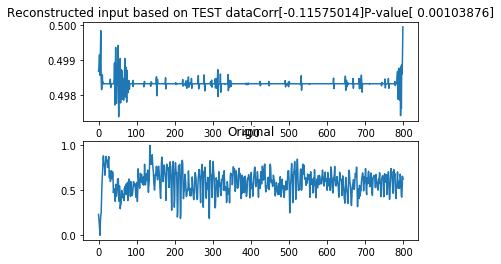

In [9]:
reconstruct_training_sample = False
chan = 30
samp = 15

from scipy.stats import pearsonr
# now let's see how the model performs:

if (reconstruct_training_sample==True):
    reconst = decoded_train[samp,:,:,:].reshape(800,1)
    orig = x_train[samp,chan,:,:].reshape(800,1)
    R,p = pearsonr(reconst, orig)
    title = "Reconstructed input based on TRAINING data" + "Corr"+ str(R) + "P-value" + str(p)
else:
    reconst = decoded_test[samp,:,:,:].reshape(800,1)
    orig = x_test[samp,chan,:,:].reshape(800,1)
    R,p = pearsonr(reconst, orig)
    title = "Reconstructed input based on TEST data" + "Corr"+ str(R) + "P-value" + str(p)


print("Pearson's R:", R, "p-value", p)
%matplotlib inline
plt.subplot(211)
plt.plot(reconst)
ax = plt.gca()
ax.set_title(title)
plt.subplot(212)
plt.plot(orig)
ax = plt.gca()
ax.set_title("Original")

In [86]:
R,p = pearsonr(reconst, orig)

In [88]:
print(R)

[ 0.04522073]
